In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import os, sys
sys.path.insert(0, os.path.abspath(".."))
from utilidades.calibration import utilities as ult

import sklearn as sk
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import optuna 
from optuna.samplers import TPESampler
from sklearn.model_selection import cross_val_score
import time
import skopt
from skopt import BayesSearchCV

import sklearn.pipeline
from sklearn.ensemble import RandomForestClassifier
from lightgbm import early_stopping
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedShuffleSplit

import skopt
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import average_precision_score

from sklearn.pipeline import Pipeline
from collections import OrderedDict
import collections



(DONE) * Lightgbm       - Algorítimico 
(DONE) * Smote          - Preprocessing

- Vini
* CDBH           - Híbrido - Email enviado - POSSIVEL IMPLEMENTAR https://sci-hub.se/10.1016/j.eswa.2020.114035
* OSM Classifier - Algorítimico - Email enviado https://sci-hub.se/10.1016/j.eswa.2018.01.008 
* SE NÃO TIVER COMO IMPLEMENTAR EU IMPLEMENTO S-CSL https://fraud-detection-handbook.github.io/fraud-detection-handbook/Chapter_6_ImbalancedLearning/CostSensitive.html

(DONE)* SVM VR         - Preprocessing 100%.
(DONE)* DBSMOTE IN R      - Preprocessing 100%


- Manaus
(DOING)* HDDT Emsemble  - Algorítimico Implementado no R 0%
(DOING)* CCR            - Preprocessing 15%

(TO DO) POTENCIAL ANCHORING      - Preprocessing

(DONE) * EasyEmsemble   - Algorítimico
(DONE)* Método novo    - Algorítimico


#### CANCELED's

(CANCELED)* EHSO           - Preprocessing
(CANCELED)* WHMBoost       - Cost Sensitivity EMAIL ENVIADO
(CANCELED)* CHMDT          - Cost Sensitivity EMAIL ENVIADO

https://www.rdocumentation.org/packages/smotefamily/versions/1.3.1/topics/DBSMOTE

-> Vini
* CDBH                     - Híbrido               INICIANDO
* OSM Classifier    - Algorítimico       NA
* SVM VR                - Preprocessing   FEITO
* DBSMOTE            - Preprocessing   FEITO

-> Manaus
* HDDT                    - Algorítimico        NA
* CCR                       - Preprocessing    FEITO
* POTENCIAL A.   - Preprocessing    FEITO
* EasyEmsemble - Algorítimico         FEITO
* Método novo     - Algorítimico         FEITO
* Lightgbm            - Algorítimico         FEITO
* Smote                  - Preprocessing     FEITO

-> On hold
* EHSO                   - Preprocessing
* WHMBoost        - Cost Sensitivity 
* CHMDT               - Cost Sensitivity

In [2]:
# try:
#     df.drop('id',axis=1, inplace=True)
# except:
#     pass
# df.diagnosis.replace('B',0,inplace=True) # Benignos para 0
# df.diagnosis.replace('M',1,inplace=True) # Malignos para 1

df = pd.read_csv('breast-cancer.csv') ; print(df.shape,df.select_dtypes('object').value_counts())
df['target'] = np.where(df['diagnosis'] == 'B',0,1)
df.drop(['diagnosis'],axis=1,inplace=True)

(569, 32) diagnosis
B            357
M            212
dtype: int64


In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
class svm_vr():
    def __init__(self, dataframe : pd.DataFrame, target: str,metric : str = 'average_precision', pipe_final : sklearn.pipeline = None):
        self.dataframe = dataframe
        self.target = target
        self.metric = metric
        self._pipe_final = pipe_final

    def fit(self,random_state=42):
        # return y_train2 é o retorno dessa função. e utilizo como resposta
        # Splito os dados aqui

        X,y = ult.splitxy(self.dataframe,self.target)

        self.X_train, self.y_train, self.X_test, self.y_test, self.X_val, self.y_val = ult.train_test_val(X,y)

        prep_feat_tuple = ult.create_prep_pipe2(self.dataframe,self.target)
        self.prep_feat = prep_feat_tuple[0]

        self.lists_pandarizer = list(prep_feat_tuple[1]) + list(prep_feat_tuple[2])

        self.pipe_prep = Pipeline([
                    ('transformer_prep', self.prep_feat),
                    ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = self.lists_pandarizer))),
                ])
        self.pipe_prep.fit(self.X_train) 
        
        self.y_train2 = self.svm_vr_y()

        LGBM = LGBMClassifier(random_state = 42, n_jobs = -1)

        pipe_tuning = Pipeline([
            ('transformer_prep', self.prep_feat),
            ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = self.lists_pandarizer))),
            ('estimator', LGBM)
        ])
        
        # self.pipe_prep = Pipeline([
        #     ('transformer_prep', self.prep_feat),
        #     ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = self.lists_pandarizer))),
        # ])
              
        
        cv = StratifiedShuffleSplit(n_splits = 5, test_size = 0.3, random_state = 42)
        
        metric = self.metric
        
        fit_params = {
            'eval_metric': metric, 
            'eval_set': [(self.X_test, pd.DataFrame(self.y_test))],
            'callbacks': [(early_stopping(stopping_rounds = 10, verbose = True))],
        }        
        
        LGBM_search_space = {
            "estimator__learning_rate": Real(0.001, 0.01, prior = 'log-uniform'),
            "estimator__n_estimators": Integer(100, 1000),
            "estimator__class_weight": Categorical(['balanced', None]),
            "estimator__num_leaves": Integer(32, 256),
            "estimator__min_child_samples": Integer(100, 1000),
            "estimator__reg_alpha": Real(0, 100, prior = 'uniform'),
            "estimator__reg_lambda": Real(10., 200., prior = 'uniform'),
            "estimator__objective": Categorical(['binary']),
            "estimator__importance_type":Categorical(['gain']),
            "estimator__boosting_type": Categorical(['goss'])
        }    
        
        LGBM_bayes_search = BayesSearchCV(pipe_tuning, LGBM_search_space, n_iter = 2, scoring = metric, 
                                         return_train_score = True, 
                                         fit_params = fit_params,
                                         n_jobs = -1, cv = cv, random_state = 42, optimizer_kwargs = {'base_estimator': 'GP'})

        # Testing if it's compatible

        from collections import Counter
        l = Counter(self.y_train2)

        if len(l.keys()) == 1:
            print('The model was not Abble to fit correctly because the SVM got all targets with the same value')
            
            LGBM_bayes_search.fit(self.X_train, self.y_train)        
            
            results_cv = pd.DataFrame(LGBM_bayes_search.cv_results_)
            
            temp = results_cv[['mean_train_score', 'mean_test_score']]
            temp['diff'] = temp['mean_test_score'] - temp['mean_train_score']
            to_go = temp[abs(temp['diff']) < 0.05].sort_values(by = 'mean_test_score', ascending = False).head(1).index
            
            params = results_cv.loc[to_go.values[0]]
            kwargs = params.params   
            
            best_LGBM = LGBMClassifier(random_state = 42, n_jobs = -1, verbose = -1, **kwargs)
            
            best_LGBM.fit(self.pipe_prep.transform(self.X_train), self.y_train, early_stopping_rounds = 10, verbose = 20, eval_metric = metric,
                        eval_set = [(self.pipe_prep.transform(self.X_test), self.y_test)]) 
            
            
            pipe_final = Pipeline(
            [
                ('pipe_transformer_prep', self.pipe_prep),
                ('pipe_estimator', best_LGBM)
            ])       
            
            self._pipe_final = pipe_final

        else:
            print('Fit was accepted')
            LGBM_bayes_search.fit(self.X_train, self.y_train2)        
            
            results_cv = pd.DataFrame(LGBM_bayes_search.cv_results_)
            
            temp = results_cv[['mean_train_score', 'mean_test_score']]
            temp['diff'] = temp['mean_test_score'] - temp['mean_train_score']
            to_go = temp[abs(temp['diff']) < 0.05].sort_values(by = 'mean_test_score', ascending = False).head(1).index
            
            params = results_cv.loc[to_go.values[0]]
            kwargs = params.params   
            
            best_LGBM = LGBMClassifier(random_state = 42, n_jobs = -1, verbose = -1, **kwargs)
            
            best_LGBM.fit(self.pipe_prep.transform(self.X_train), self.y_train, early_stopping_rounds = 10, verbose = 20, eval_metric = metric,
                        eval_set = [(self.pipe_prep.transform(self.X_test), self.y_test)]) 
            
            
            pipe_final = Pipeline(
            [
                ('pipe_transformer_prep', self.pipe_prep),
                ('pipe_estimator', best_LGBM)
            ])       
            
            self._pipe_final = pipe_final

    def svm_vr_y(self,random_state=42):
        """ This function fits a SVM Classifier, taking the best result from the grid searching.
        After the best fit has been achieved, the training dependent variable values must be replaced by the predicts of the trained model, thus obtaining the balancing.

        Following the instructions of the Authors.
        They suggest using higher values for C and the RBF kernel function.

        "The proposed methodology followed a two phase
        approach. During the first phase the available training data is used
        to train SVM. Later, the target values of the training data are replaced
        by the corresponding predictions of the trained SVM. During the
        second phase, this modified data is used to train MLP, LR, and RF
        separately" Authors.

        Based on the ideia by the authors, we select the best model, by the value of accuracy
        """
        metric = self.metric
        SVM = SVC(random_state=42)

        pipe_tuning = Pipeline([
            ('transformer_prep', self.prep_feat),
            ("pandarizer", FunctionTransformer(lambda x: pd.DataFrame(x, columns = self.lists_pandarizer))),
            ('estimator', SVM)
        ])

        SVC_search_space = {
            "estimator__C": Integer(5, 10),   
            "estimator__gamma": Integer(5, 10),
            "estimator__degree": Integer(1,8),
            "estimator__kernel": Categorical(['linear', 'poly', 'rbf','sigmoid'])
        }   

        SVM_vr_search = BayesSearchCV(
            pipe_tuning,
            SVC_search_space,   
            n_iter=2,
            random_state=42,
            cv=5,
            scoring=metric,
            return_train_score=True
        )
        SVM_vr_search.fit(self.pipe_prep.transform(self.X_train), self.y_train)

        results_cv = pd.DataFrame(SVM_vr_search.cv_results_)
        
        temp = results_cv[['mean_train_score', 'mean_test_score']]
        temp['diff'] = temp['mean_test_score'] - temp['mean_train_score']
        to_go = temp[abs(temp['diff']) < 0.2].sort_values(by = 'mean_test_score', ascending = False).head(1).index
        
        params = results_cv.loc[to_go.values[0]]
        kwargs = params.params
        kwargs = collections.OrderedDict((key.replace('estimator__', ''), value) for key, value in kwargs.items())

        best_SVM = SVC(random_state=random_state,**kwargs).fit(self.pipe_prep.transform(self.X_train),self.y_train)
        y_train2= best_SVM.predict(self.X_train)
        return y_train2
    
    def predict_proba(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = ult.splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = ult.train_test_val(X,y)        
        
        dic = {'val': X_val, 
              'test': X_test,
              'train': X_train}
        y_score = self._pipe_final.predict_proba(dic[who])[:,1]
        return y_score
    
    def get_metric(self, who : str = 'val'):
        if self._pipe_final is None:
            return None
        
        X, y = ult.splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = ult.train_test_val(X,y)
        
        dic_x = {'val': X_val, 
              'test': X_test,
              'train': X_train}

        dic_y = {'val': y_val, 
              'test': y_test,
              'train': y_train}
        
        
        y_score = self._pipe_final.predict_proba(dic_x[who])[:,1]
        average_precision = average_precision_score(dic_y[who], y_score)
        return average_precision
    
    
    def plot_dist(self):
        if self._pipe_final is None:
            return None        

        X, y = ult.splitxy(self.dataframe, self.target)
        X_train, y_train, X_test, y_test, X_val, y_val = ult.train_test_val(X,y)        
        
        y_score_train = self._pipe_final.predict_proba(X_train)[:,1]
        y_score_val = self._pipe_final.predict_proba(X_val)[:,1]
        
        ult.plot_dist(y_train, y_score_train, y_val, y_score_val)
        


In [5]:
svm_testing = svm_vr(df, 'target')
svm_testing.fit()
svm_testing._pipe_final

The model was not Abble to fit correctly because the SVM got all targets with the same value
[20]	valid_0's average_precision: 0.971402	valid_0's binary_logloss: 0.223291


Pipeline(steps=[('pipe_transformer_prep',
                 Pipeline(steps=[('transformer_prep',
                                  FeatureUnion(transformer_list=[('num_pipe',
                                                                  Pipeline(steps=[('selector_num',
                                                                                   ColumnTransformer(transformers=[('selector',
                                                                                                                    'passthrough',
                                                                                                                    array(['id', 'radius_mean', 'texture_mean', 'perimeter_mean', 'area_mean',
       'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_m...
                 LGBMClassifier(estimator__boosting_type='goss',
                                estimator__class_weight=None,
                                estimator__importance_type='gain',
                                estimator__learning_rate=0.002069186296126171,
                                estimator__min_child_samples=703,
                                estimator__n_estimators=473,
                                estimator__num_leaves=111,
                                estimator__objective='binary',
                                estimator__reg_alpha=30.44633110365062,
                                estimator__reg_lambda=133.08040178590676,
                                random_state=42, verbose=-1))])

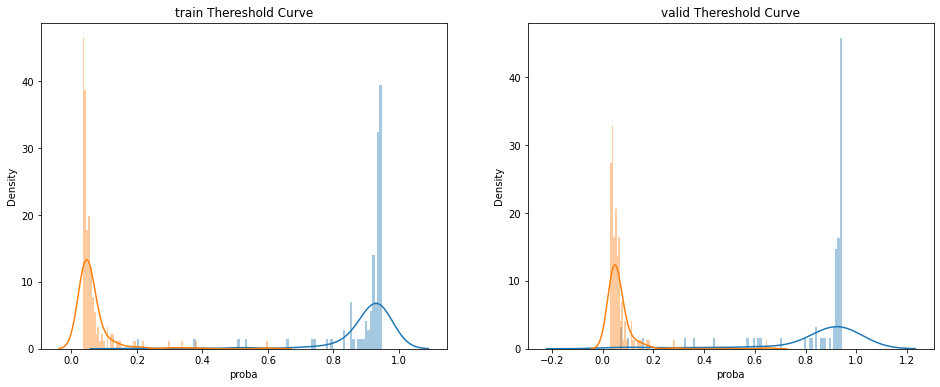

In [6]:
svm_testing.plot_dist()